<a href="https://colab.research.google.com/github/hhauschild/keras-playground/blob/master/liveproject_dl_predict_5_hyperparam_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. prepare

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

gameurl = r'https://liveproject-resources.s3.amazonaws.com/other/deeplearningbasketballscores/Games-Calculated.csv'
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df = pd.read_csv(gameurl, header = None, \
                      names=["date","home_team","home_score", "away_team","away_score", \
                             "home_sc_avg", \
                             "home_defensive_avg", "away_sc_avg", "away_defensive_avg", "result" ] ,\
                      parse_dates=["date"], \
                      dtype={"home_team":str,"home_score":int,"away_team":str,\
                             "away_score":int, "home_sc_avg":float, \
                             "home_defensive_avg":float, "away_sc_avg":float,  \
                             "away_defensive_avg":float, "result":int} \
                      );
df.head()

,date,home_team,home_score,away_team,away_score,home_sc_avg,home_defensive_avg,away_sc_avg,away_defensive_avg,result
0,2015-11-13,Hawaii,87,Montana State,76,87.0,76.0,76.0,87.0,11
1,2015-11-13,Eastern Michigan,70,Vermont,50,70.0,50.0,50.0,70.0,20
2,2015-11-13,Yale,70,Fairfield,57,70.0,57.0,57.0,70.0,13
3,2015-11-13,Central Michigan,89,Jacksonville State,83,89.0,83.0,83.0,89.0,6
4,2015-11-13,Iowa State,68,Colorado,62,68.0,62.0,62.0,68.0,6


In [2]:
# remove irrelevant columns (the (uncalculated) original raw data)
df.drop(["date","home_team","home_score", "away_team","away_score"], axis=1, inplace=True, errors='ignore')

# split 80:20
df_x_train= df.sample(frac=.8, random_state=0)
df_x_valid= df.drop(df_x_train.index)

print(df_x_train.shape[0])

# cut off y
df_y_train = df_x_train.pop('result')
df_y_valid = df_x_valid.pop('result')

# normalize
train_x_mean = df_x_train.mean(axis = 0)
df_x_train_normalized = df_x_train - train_x_mean
train_x_stdd = df_x_train_normalized.std(axis=0)
df_x_train_normalized /= train_x_stdd

df_x_valid_normalized = (df_x_valid - train_x_mean) / train_x_stdd

df_x_train_normalized.head()

16128


,home_sc_avg,home_defensive_avg,away_sc_avg,away_defensive_avg
5951,0.466862,-0.564797,-0.104406,0.664043
15481,-1.813378,-0.040936,0.689466,0.730448
16660,1.891701,0.354039,0.341276,-0.557815
4896,-0.538980,-0.325040,-0.997915,1.072691
12061,0.540443,-0.318741,-0.271538,-0.079697


NN 1


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
252/252 [==============================] - 0s 2ms/step - loss: 144.1512 - mean_squared_error: 144.1512 - accuracy: 0.0000e+00 - mean_absolute_error: 9.3721 - val_loss: 106.3422 - val_mean_squared_error: 106.3422 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 7.9896
Epoch 2/50
252/252 [==============================] - 0s 1ms/step - loss: 104.8875 - mean_squar

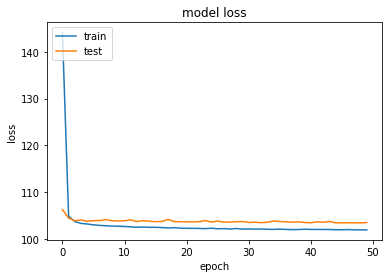

In [3]:
from keras.models import Sequential 
from keras.layers import Activation, Dense
from keras import losses 
from keras import optimizers 
from keras import metrics 
model = Sequential([Dense(32, activation= "relu", input_shape=[4]),Dense(32, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(df_x_valid_normalized, df_y_valid),
)
plt.plot(gg.history["loss"])
plt.plot(gg.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


NN2

In [4]:
# one extra intermediate layer
model = Sequential([Dense(32, activation= "relu", input_shape=[4]),Dense(32, activation= "relu"),Dense(32, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=0,
    validation_data=(df_x_valid_normalized, df_y_valid),
)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
gg.history['mean_absolute_error'][-1:]

[7.836406707763672]

small improvement. Let's reduce the intermediate layer size. 

NN3


In [16]:
# half size of intermediate layers
model = Sequential([Dense(16, activation= "relu", input_shape=[4]),Dense(16, activation= "relu"),Dense(16, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=0,
    validation_data=(df_x_valid_normalized, df_y_valid),
)
gg.history['mean_absolute_error'][-1:]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


[7.866527557373047]

result is getting worse. Let's double the intermediate layer size instead

NN4

In [17]:
# double size of intermediate layers
model = Sequential([Dense(64, activation= "relu", input_shape=[4]),Dense(64, activation= "relu"),Dense(64, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=0,
    validation_data=(df_x_valid_normalized, df_y_valid),
)
gg.history['mean_absolute_error'][-1:]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
None


[7.827488899230957]

This is the best result so far. Let's add one more layer

NN5

In [18]:
# add another layer
model = Sequential([Dense(64, activation= "relu", input_shape=[4]),Dense(64, activation= "relu"),Dense(64, activation= "relu"),Dense(64, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=0,
    validation_data=(df_x_valid_normalized, df_y_valid),
)
gg.history['mean_absolute_error'][-1:]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None


[7.800007343292236]

So far, each extra layer and each addition in layer size have improved the result. Lets blow up the model in bigger steps now

In [19]:
# more and bigger layers
model = Sequential([Dense(1024, activation= "relu", input_shape=[4]),Dense(1024, activation= "relu"),Dense(1024, activation= "relu"),Dense(1024, activation= "relu"),Dense(1024, activation= "relu"),Dense(1024, activation= "relu"),Dense(1024, activation= "relu"),Dense(1)])

print(model.summary())

model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(), metrics = [metrics.MeanSquaredError(),metrics.Accuracy(),metrics.MeanAbsoluteError()])

# train the model

gg = model.fit(
    x=df_x_train_normalized,
    y=df_y_train,
    batch_size=64,
    epochs=50,
    verbose=0,
    validation_data=(df_x_valid_normalized, df_y_valid),
)
gg.history['mean_absolute_error'][-1:]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_30 (Dense)             (None, 1024)             

[7.711993217468262]

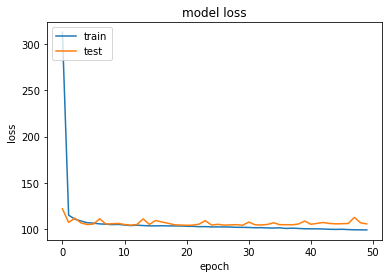

In [20]:
# let's check if we are overfitting
plt.plot(gg.history["loss"])
plt.plot(gg.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

looks like we should stop after 20 epochs. Oherwise ok.
